In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors

spark = SparkSession.builder.appName("RegressaoLogistica").getOrCreate()

# Criar dataset pequeno e didático
dados = spark.createDataFrame([
    (25, 20.0, 0),  # jovem, magro → baixo risco
    (45, 30.0, 1),  # meia idade, sobrepeso → alto risco
    (35, 25.0, 0),  # adulto, peso normal → baixo risco
    (50, 35.0, 1),  # mais velho, obeso → alto risco
    (29, 22.0, 0),  # jovem, peso normal → baixo risco
    (60, 33.0, 1)   # idoso, sobrepeso → alto risco
], ["idade", "imc", "risco"])
dados.show()

+-----+----+-----+
|idade| imc|risco|
+-----+----+-----+
|   25|20.0|    0|
|   45|30.0|    1|
|   35|25.0|    0|
|   50|35.0|    1|
|   29|22.0|    0|
|   60|33.0|    1|
+-----+----+-----+



In [6]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["idade", "imc"],outputCol="features")
dados_vetorizados = assembler.transform(dados).select("features", "risco")

In [7]:
dados_vetorizados.show()

+-----------+-----+
|   features|risco|
+-----------+-----+
|[25.0,20.0]|    0|
|[45.0,30.0]|    1|
|[35.0,25.0]|    0|
|[50.0,35.0]|    1|
|[29.0,22.0]|    0|
|[60.0,33.0]|    1|
+-----------+-----+



In [9]:
from pyspark.ml.classification import LogisticRegression
modelo = LogisticRegression(featuresCol="features", labelCol="risco")

In [10]:
modelo_treinado = modelo.fit(dados_vetorizados)

In [12]:
previsoes = modelo_treinado.transform(dados_vetorizados)

In [14]:
previsoes.select("features", "risco", "prediction", "probability").show(truncate=False)

+-----------+-----+----------+-----------------------------------------+
|features   |risco|prediction|probability                              |
+-----------+-----+----------+-----------------------------------------+
|[25.0,20.0]|0    |0.0       |[1.0,0.0]                                |
|[45.0,30.0]|1    |1.0       |[4.21919865458999E-8,0.9999999578080134] |
|[35.0,25.0]|0    |0.0       |[0.9999999489294326,5.107056744169114E-8]|
|[50.0,35.0]|1    |1.0       |[1.5463294756202543E-19,1.0]             |
|[29.0,22.0]|0    |0.0       |[1.0,0.0]                                |
|[60.0,33.0]|1    |1.0       |[1.0234390648282893E-22,1.0]             |
+-----------+-----+----------+-----------------------------------------+



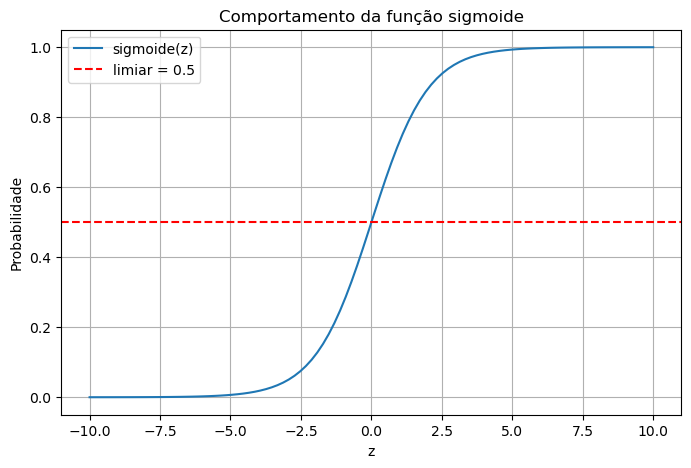

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Função sigmoide
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 100)
p = sigmoide(z)

plt.figure(figsize=(8,5))
plt.plot(z, p, label="sigmoide(z)")
plt.axhline(0.5, color='red', linestyle='--', label="limiar = 0.5")
plt.xlabel("z")
plt.ylabel("Probabilidade")
plt.title("Comportamento da função sigmoide")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
iris_df = spark.read.csv("iris.csv",header=True,inferSchema=True)
iris_df.show(10)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
|         5.4|        3.9|         1.7|        0.4| setosa|
|         4.6|        3.4|         1.4|        0.3| setosa|
|         5.0|        3.4|         1.5|        0.2| setosa|
|         4.4|        2.9|         1.4|        0.2| setosa|
|         4.9|        3.1|         1.5|        0.1| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 10 rows



In [25]:
iris_df.select("species").distinct().show()

+----------+
|   species|
+----------+
| virginica|
|versicolor|
|    setosa|
+----------+



In [26]:
from pyspark.ml.feature import StringIndexer
indexador = StringIndexer(inputCol="species", outputCol="label")
iris_df = indexador.fit(iris_df).transform(iris_df)
iris_df.show(5)

+------------+-----------+------------+-----------+-------+-----+
|sepal_length|sepal_width|petal_length|petal_width|species|label|
+------------+-----------+------------+-----------+-------+-----+
|         5.1|        3.5|         1.4|        0.2| setosa|  0.0|
|         4.9|        3.0|         1.4|        0.2| setosa|  0.0|
|         4.7|        3.2|         1.3|        0.2| setosa|  0.0|
|         4.6|        3.1|         1.5|        0.2| setosa|  0.0|
|         5.0|        3.6|         1.4|        0.2| setosa|  0.0|
+------------+-----------+------------+-----------+-------+-----+
only showing top 5 rows



In [27]:
iris_df.select("label").distinct().show()

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
+-----+



In [30]:
from pyspark.ml.feature import VectorAssembler 

assembler = VectorAssembler(
    inputCols=["sepal_length", "sepal_width", "petal_length","petal_width"],
    outputCol="features"
)
dados_modelo = assembler.transform(iris_df).select("features","label") 

In [33]:
dados_modelo.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[5.1,3.5,1.4,0.2]|  0.0|
|[4.9,3.0,1.4,0.2]|  0.0|
|[4.7,3.2,1.3,0.2]|  0.0|
|[4.6,3.1,1.5,0.2]|  0.0|
|[5.0,3.6,1.4,0.2]|  0.0|
+-----------------+-----+
only showing top 5 rows



In [34]:
train, test = dados_modelo.randomSplit([0.8,0.2], seed=42)

In [36]:
lr = LogisticRegression(featuresCol= "features", labelCol="label",maxIter=20)
modelo_treinado = lr.fit(train)

In [37]:
previsoes = modelo_treinado.transform(test)

In [39]:
previsoes.select("features", "label", "prediction", "probability").show(truncate=False)

+-----------------+-----+----------+-----------------------------------------------------------------+
|features         |label|prediction|probability                                                      |
+-----------------+-----+----------+-----------------------------------------------------------------+
|[4.4,3.0,1.3,0.2]|0.0  |0.0       |[0.9999997075128654,2.924871346257836E-7,2.17235696971913E-30]   |
|[4.6,3.2,1.4,0.2]|0.0  |0.0       |[0.9999996462929218,3.5370707821278717E-7,1.0398673899086775E-30]|
|[4.6,3.6,1.0,0.2]|0.0  |0.0       |[0.9999999976545073,2.3454927323248353E-9,1.3038338868273534E-35]|
|[4.8,3.1,1.6,0.2]|0.0  |0.0       |[0.9999889890301625,1.1010969837490735E-5,2.42019185823694E-28]  |
|[4.9,3.1,1.5,0.1]|0.0  |0.0       |[0.9999882479689507,1.1752031049199773E-5,1.6325308368074025E-29]|
|[5.0,2.3,3.3,1.0]|1.0  |1.0       |[3.395469314101735E-4,0.9996604465465445,6.52204531717474E-9]    |
|[5.0,3.5,1.3,0.3]|0.0  |0.0       |[0.9999987679172214,1.232082778473367

In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(previsoes)
print(f"🎯 Acurácia Multiclasse: {acc:.4f}")

🎯 Acurácia Multiclasse: 1.0000
